In [2]:
import numpy as np
import torch as tc
import random
from torch.utils.data import Dataset, DataLoader
import seaborn as sb
import pandas as pd
#from Classes import *
#from functions import *
#from Train_Env import *

net found, loading net
0
torch.Size([730, 189]) tensor(69202)
tensor([0.1542, 0.1815, 0.1177, 0.2576, 0.2087, 0.2672, 0.3862, 0.1728, 0.3228,
        0.1879, 0.2468, 0.8860, 0.2072, 1.2284, 0.1508, 0.2659, 0.3922, 0.1988,
        0.2284, 0.1723, 0.2420, 0.1599, 0.2243, 0.2796, 0.2315, 0.2224, 0.4246,
        0.4568, 0.1934, 0.5742, 0.2629, 0.1607, 0.2416, 0.1440, 0.1606, 0.2686,
        0.1231, 0.2314, 0.1734, 0.5795, 0.3258, 0.3078, 0.5122, 0.2958, 0.2097,
        0.3962, 0.1619, 0.2655, 0.2894, 0.3591, 0.1383, 0.2722, 0.2265, 0.1338,
        0.7590, 0.1372, 0.2136, 0.2014, 0.1778, 0.3146, 0.1459, 0.2144, 0.1694,
        0.4542, 0.3819, 0.3576, 0.1942, 0.1690, 0.1921, 0.1357, 0.1726, 0.4052,
        0.1720, 0.2315, 0.1682, 0.2405, 0.4103, 0.1682, 0.2151, 0.4077, 0.1773,
        0.2339, 0.3101, 0.1429, 0.1108, 0.2444, 0.1582, 0.1434, 0.2160, 0.1389,
        0.3579, 0.4297, 0.4288, 0.2887, 0.3606, 0.1067, 0.1758, 0.1941, 0.2213,
        0.3655, 0.3258, 0.3216, 0.2151, 0.1972, 0.1868, 0.

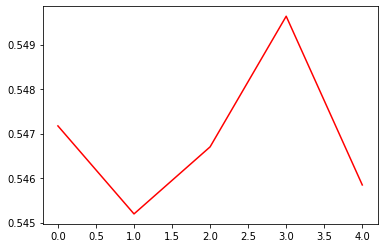

KeyboardInterrupt: 

In [10]:
data_with_names = pd.read_csv('../data2/TCPA_data_sel.csv')
ID, data = data_with_names.iloc[:,:2], tc.tensor(data_with_names.iloc[:,2:].values)

train_dist = ((0.1,0.9))
test_dist = (0.50)
activations = [nn.ReLU()]
n_epochs = 30
test_every = 5
width =40
depth= 4
variational = True
lr = 0.0001
sample_width = 1024

train_env = Train_env(data, load_model=True)  # specify network
train_env.train_network(width, sample_width, depth, variational, train_dist, test_dist, n_epochs=n_epochs, test_every=test_every) # specify training and test

In [5]:
class Normaldataset(Dataset):
    def __init__(self, data):
        self.data = data
 
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        return self.data[i, :].float()
    

class Mask_n():
    def __init__(self, data, batchsize):
        self.dataset = Normaldataset(data)
        self.nsamples, self.nfeatures = data.shape
        self.batchsize = batchsize
        self.dataloader = DataLoader(self.dataset, batchsize, shuffle=False)
        self.mask = [tc.tensor(np.random.permutation(self.nfeatures)) for _ in range(self.batchsize)]
        self.seed = random.random()
        
    def get_nmasked(self, n): # müsste get_n_unmasked heißen......
        n = self.nfeatures-n # einmal umgedreht
        batch = next(iter(self.dataloader))
        masked_data, target_data = batch.clone(), batch.clone()
        for i in range(self.batchsize):
            masked_data[i][self.mask[i][:n]] = float('nan')
        
        last_mask = [mask[-1] for mask in self.mask]
        
        return masked_data.float(), target_data.float(), last_mask
    
mask_n = Mask_n(data, 10)
ind = mask_n.get_nmasked(5)[2]


In [12]:
m = mask_n.get_nmasked(180)
m[0].shape

torch.Size([10, 189])

In [428]:
'''
###batched
class MCShapley:
    def __init__(data, net, truncation):
        self.data = data
        self.nsamples, self.nfeatures = data.shape
        self.net = net
        self.truncation = truncation
        self.criterion = F.mse_loss
        
        self.phi = tc.zeros(self.nfeatures, self.n_features)        
    
    def step(t):
        mask_n = Mask_n(self.data, batch_size=10)
        jmasked,target,last_mask = mask.get_nmasked(0)
        v_j = self.criterion(net(jmasked), target, reduction='none') 
        
        self.v_all = self.net(mask.get_nmasked(self.nfeatures))
        for j in range(1,self.nfeatures):
            jmasked, target, last_mask = mask.get_nmasked(j)
            v_j_new = self.criterion(self.net(jmasked), target, reduction='none')
            for i in range(batch_size):
                phi[last_mask[i],:] = (t-1)/t * phi[last_mask[i],:] + 1/t*(v_j_new[i,:]-v_j[i,:])    
'''  
                
###not batched
class MCShapley:
    def __init__(self, data, net, truncation=0.0001):
        self.data = data
        self.nsamples, self.nfeatures = data.shape
        self.net = net
        self.truncation = truncation
        self.criterion = F.mse_loss
        self.t = tc.tensor([0.0]).to(device)
        self.phi = tc.zeros(self.nfeatures, self.nfeatures).to(device)      
        print(self.phi)
    
    def step(self):
        self.t+=1
        mask_n = Mask_n(self.data, batchsize=1)
        jmasked,target,last_mask = mask_n.get_nmasked(0)
        jmasked, target = jmasked.to(device), target.to(device)

        full_set = mask_n.get_nmasked(self.nfeatures)[0].cuda()
        
        v_j = self.criterion(self.net(jmasked), target, reduction='none') 
        v_all = self.net(full_set)
        if abs(v_all-v_j)<self.truncation:
            continue
            
        for j in range(1,self.nfeatures):
            jmasked, target, last_mask = mask_n.get_nmasked(j)
            jmasked, target= jmasked.to(device), target.to(device)
            
            v_j_new = self.criterion(self.net(jmasked), target, reduction='none')
            self.phi[last_mask,:] = (self.t-1)/self.t * self.phi[last_mask,:] + 1/self.t*(v_j_new-v_j)
            v_j = v_j_new



In [21]:
device = tc.device("cpu")
train_env = Train_env(data, load_model=True)  # specify network
#train_env.train_network(width, depth, variational, train_dist, test_dist, n_epochs=n_epochs, test_every=test_every) # specify training and test
net = train_env.net.cuda().eval()
net.SHAP=True
mcshapley = MCShapley(data,net,truncation = 0.001)
for epoch in range(1000):
    mcshapley.step()


NameError: name 'Train_env' is not defined

In [22]:
# def masker
# set p, set q
# sample a vector S (selection)
# set X to random values where not S (scramble all rows of X where not S)
# return with masked p
# return without masked p

# PQmat = empty_matrix
# for p, q in len(dims)

    # diffs = []
    # while not converged ()
        # load batch
        # run masker(p, q)
        # validate model (later: 3 fold)
        # diffs.append(difference(loss(with p), loss(without p)))
        # check convergence difference(mean(diffs-t1), mean(diffs-t0)) < epsilon

In [11]:
#notes
# require mask (mask hides values)
# require X is n x d

# get range e.g. r = np.arange(d)
# repeat r (n)-times e.g. R = np.repeat
# np.shuffle(R)
# Xperm = X[R]
# select where X[~mask] Xperm[mask], e.g. numpy.where


In [1]:
import torch as tc
device = tc.device('cpu')
import torch.nn as nn
import BoostNet
import RecursiveNet
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd

data_with_names = pd.read_csv('../data2/TCPA_data_sel.csv')
ID, data = data_with_names.iloc[:,:2], tc.tensor(data_with_names.iloc[:,2:].values)


train_dist = ((0.1,0.9))
test_dist = (0.50)
activations = [nn.ReLU()]
n_epochs = 1
test_every = 1
width =20
sample_width = 10
depth= 5
variational = True
lr = 0.0001
repeats = 8
#make training environment
train_env = RecursiveNet.Train_env(data, load_model=True, device=device) #use either BoostNet or RecursiveNet
# specify and train network
#train_env.train_network(width, sample_width, depth, variational, train_dist, test_dist, lr=lr, n_epochs=n_epochs, test_every=test_every, repeats = repeats) # specify training and test


recursivenet found, loading net


In [2]:
class ShapleySet(Dataset):
    def __init__(self,data, p, q):
        self.data = data.float()
        self.nsamples, self.nfeatures = data.shape
        self.R = self.init_randomsample()
        self.p = p
        self.q = q
        self.Set, self.Setp = None, None
        self.getSets()
        
    def init_randomsample(self):
        tensor_list = [self.data[tc.randperm(self.nsamples),i] for i in range(self.nfeatures)]
        return tc.stack(tensor_list).t()

    def getSets(self):
        self.Set = tc.distributions.bernoulli.Bernoulli(tc.tensor([0.5]*self.nfeatures)).sample()
        self.Set[self.q] = 0 # muss das sein
        self.Setp = self.Set.clone()
        self.Set[self.p], self.Setp[self.p] = 0,1
    
    def __len__(self):
        return self.nsamples
    
    def __getitem__(self, idx):
        assert self.Set is not None, ('did not sample')
        target = self.data[idx,:]
        random_values = self.R[idx,:]
        
        masked_data = tc.where(self.Set==1, target, random_values)
        masked_dataP = tc.where(self.Setp==1, target, random_values)

        return target, masked_data, self.Set, masked_dataP, self.Setp

In [12]:
class Shapley():
    def __init__(self, data, net):
        self.data = data
        self.nsamples, self.nfeatures = data.shape
        self.net = net
        self.shapleyvalues = tc.zeros(self.nsamples, self.nfeatures)
        
    def calc_shapleypq(self, p, q, steps = 1000):
        self.shapleyset = ShapleySet(self.data,p,q)
        self.shapleyloader = DataLoader(self.shapleyset, batch_size = 50) #self.nsamples)
        meandiff = tc.zeros(1)
        criterion= F.mse_loss
        proceed = True
        
        for t in range(1, 20):
            for target, masked_data, Set, masked_dataP, SetP in self.shapleyloader:
                target, masked_data, Set, masked_dataP, SetP = target.to(device), masked_data.to(device), Set.to(device), masked_dataP.to(device), SetP.to(device)
                pred, predP = self.net(masked_data, Set), self.net(masked_dataP, SetP)
                loss, lossP = criterion(pred, target), criterion(predP, target)

                meanloss, meanlossP = loss.to(device), lossP.to(device)
                meandiff = (t-1)/t * meandiff + 1/t * (meanloss - meanlossP)
            self.shapleyvalues[p,q] = meandiff
            print(p,q,meandiff)
            
    def calc_shapleyAll(self):
        for p in range(self.nfeatures):
            for q in range(self.nfeatures):
                self.calc_shapleypq(p,q)
        
    

In [13]:
shapleyset=ShapleySet(data, 1,1)

In [14]:
shapley = Shapley(data, train_env.net)

1 1 tensor([0.0054], grad_fn=<AddBackward0>)
1 1 tensor([0.0009], grad_fn=<AddBackward0>)
1 1 tensor([-0.0027], grad_fn=<AddBackward0>)
1 1 tensor([-0.0001], grad_fn=<AddBackward0>)
1 1 tensor([0.0031], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [1]:
a = [1,2,3,4,4,5,6]
max(a)

6

NameError: name 'net' is not defined

In [17]:
next(train_env.net.parameters()).device

device(type='cpu')